In [1]:
# display datasets already in databricks;pull census data
display(dbutils.fs.ls("/databricks-datasets"))
%fs ls databricks-datasets/adult/adult.data

path,name,size
dbfs:/databricks-datasets/README.md,README.md,976
dbfs:/databricks-datasets/Rdatasets/,Rdatasets/,0
dbfs:/databricks-datasets/SPARK_README.md,SPARK_README.md,3359
dbfs:/databricks-datasets/adult/,adult/,0
dbfs:/databricks-datasets/airlines/,airlines/,0
dbfs:/databricks-datasets/amazon/,amazon/,0
dbfs:/databricks-datasets/asa/,asa/,0
dbfs:/databricks-datasets/atlas_higgs/,atlas_higgs/,0
dbfs:/databricks-datasets/bikeSharing/,bikeSharing/,0
dbfs:/databricks-datasets/cctvVideos/,cctvVideos/,0


In [2]:
%sql 
-- drop the table if it already exists
DROP TABLE IF EXISTS adult

In [3]:
%sql
-- create a new table in Spark SQL from the datasets already loaded in the underlying filesystem.
 
CREATE TABLE adult (
  age DOUBLE,
  workclass STRING,
  fnlwgt DOUBLE,
  education STRING,
  education_num DOUBLE,
  marital_status STRING,
  occupation STRING,
  relationship STRING,
  race STRING,
  sex STRING,
  capital_gain DOUBLE,
  capital_loss DOUBLE,
  hours_per_week DOUBLE,
  native_country STRING,
  income STRING)
USING com.databricks.spark.csv
OPTIONS (path "/databricks-datasets/adult/adult.data", header "true")

In [4]:
# look at the data

display(spark.sql("SELECT * FROM adult LIMIT 5"))

age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
37.0,Private,284582.0,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K


In [5]:
# get summary marital status rates by occupation,ltrim removes leading spaces from string,lower converts to lower case
result = spark.sql(
  """
  SELECT 
    occupation,
    SUM(1) as n,
    ROUND(AVG(if(LTRIM(marital_status) LIKE 'Married-%',1,0)),2) as married_rate,
    ROUND(AVG(if(lower(marital_status) LIKE '%widow%',1,0)),2) as widow_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Divorced',1,0)),2) as divorce_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Separated',1,0)),2) as separated_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Never-married',1,0)),2) as bachelor_rate
  FROM 
    adult 
  GROUP BY 1
  ORDER BY n DESC
  LIMIT 5
  """)
display(result)

occupation,n,married_rate,widow_rate,divorce_rate,separated_rate,bachelor_rate
Prof-specialty,4140,0.53,0.02,0.13,0.02,0.3
Craft-repair,4099,0.64,0.01,0.11,0.03,0.21
Exec-managerial,4066,0.61,0.02,0.15,0.02,0.2
Adm-clerical,3769,0.28,0.04,0.22,0.04,0.42
Sales,3650,0.47,0.03,0.12,0.03,0.36


In [6]:
# register the df as a table for spark sql
sqlContext.registerDataFrameAsTable(result, "result")
spark.sql("SELECT * FROM result").show(5)

+----------------+----+------------+----------+------------+--------------+-------------+
 occupation| n|married_rate|widow_rate|divorce_rate|separated_rate|bachelor_rate|
+----------------+----+------------+----------+------------+--------------+-------------+
 Prof-specialty|4140| 0.53| 0.02| 0.13| 0.02| 0.3|
 Craft-repair|4099| 0.64| 0.01| 0.11| 0.03| 0.21|
 Exec-managerial|4066| 0.61| 0.02| 0.15| 0.02| 0.2|
 Adm-clerical|3769| 0.28| 0.04| 0.22| 0.04| 0.42|
 Sales|3650| 0.47| 0.03| 0.12| 0.03| 0.36|
+----------------+----+------------+----------+------------+--------------+-------------+
only showing top 5 rows

In [7]:
#1).Write spark sql to get top 'bachelor_rate' by 'education' group?
result = spark.sql(
  """
  SELECT 
    education,
    ROUND(AVG(if(LTRIM(marital_status) = 'Never-married',1,0)),2) as bachelor_rate
  FROM 
    adult 
  GROUP BY education
  ORDER BY 2 desc 
  LIMIT 1
  
  """)
display(result)

education,bachelor_rate
12th,0.54


In [8]:
#register a df from the sql df
df_adult = spark.table("adult")
cols = df_adult.columns 


In [9]:
# look at df schema
df_adult.printSchema()

root
-- age: double (nullable = true)
-- workclass: string (nullable = true)
-- fnlwgt: double (nullable = true)
-- education: string (nullable = true)
-- education_num: double (nullable = true)
-- marital_status: string (nullable = true)
-- occupation: string (nullable = true)
-- relationship: string (nullable = true)
-- race: string (nullable = true)
-- sex: string (nullable = true)
-- capital_gain: double (nullable = true)
-- capital_loss: double (nullable = true)
-- hours_per_week: double (nullable = true)
-- native_country: string (nullable = true)
-- income: string (nullable = true)

In [10]:
# look at the df
df_adult.show(5)

+----+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
 age| workclass| fnlwgt| education|education_num| marital_status| occupation| relationship| race| sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+----+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
50.0| Self-emp-not-inc| 83311.0| Bachelors| 13.0| Married-civ-spouse| Exec-managerial| Husband| White| Male| 0.0| 0.0| 13.0| United-States| <=50K|
38.0| Private|215646.0| HS-grad| 9.0| Divorced| Handlers-cleaners| Not-in-family| White| Male| 0.0| 0.0| 40.0| United-States| <=50K|
53.0| Private|234721.0| 11th| 7.0| Married-civ-spouse| Handlers-cleaners| Husband| Black| Male| 0.0| 0.0| 40.0| United-States| <=50K|
28.0| Private|338409.0| Bachelors| 13.0| Married-civ-spouse| Prof-specialty| Wife| Black| Female| 0.0| 0.0| 40.0| Cuba| <=50K|
37.0| Private|284582.0| Masters| 14.0| Married-civ-spouse| Exec-managerial| Wife| White| Female| 0.0| 0.0| 40.0| United-States| <=50K|
+----+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
only showing top 5 rows

In [11]:
# import functions
from pyspark.sql.functions import when, col, mean, desc, round

# wrangle data 
df_result = df_adult.select(
  df_adult['occupation'], 
  # create a 1/0 type col 
  when( col('marital_status') == ' Divorced' , 1 ).otherwise(0).alias('is_divorced')
)
# grouping (and round)
df_result = df_result.groupBy('occupation').agg(round(mean('is_divorced'),2).alias('divorced_rate'))
# ordering
df_result = df_result.orderBy(desc('divorced_rate'))
# show results
df_result.show(5)

+----------------+-------------+
 occupation|divorced_rate|
+----------------+-------------+
 Adm-clerical| 0.22|
 Priv-house-serv| 0.19|
 Other-service| 0.15|
 Tech-support| 0.15|
 Exec-managerial| 0.15|
+----------------+-------------+
only showing top 5 rows

In [12]:
#2).Write pyspark to get top 'bachelor_rate' by 'education' group using DataFrame operations
df_result = spark.sql(
  """
  SELECT 
    education,
    ROUND(AVG(if(LTRIM(marital_status) = 'Never-married',1,0)),2) as bachelor_rate
  FROM 
    adult 
  GROUP BY education
  ORDER BY 2 desc 
  LIMIT 1
  
  """)
df_result.show(1)

+---------+-------------+
education|bachelor_rate|
+---------+-------------+
 12th| 0.54|
+---------+-------------+

In [13]:
import pandas as pd

# do  analysis
result = spark.sql(
  """
  SELECT 
    occupation,
    AVG(IF(income = ' >50K',1,0)) as plus_50k
  FROM 
    adult 
  GROUP BY 1
  ORDER BY 2 DESC
  """)

# collect results into a pandas df
df_pandas = pd.DataFrame(
  result.collect(),
  columns=result.schema.names
)

# look at df
print(df_pandas.head())

occupation plus_50k
0 Exec-managerial 0.484014
1 Prof-specialty 0.449034
2 Protective-serv 0.325116
3 Tech-support 0.304957
4 Sales 0.269315

In [14]:
print(df_pandas.describe())

plus_50k
count 15.000000
mean 0.197357
std 0.143993
min 0.006711
25% 0.107373
50% 0.134518
75% 0.287136
max 0.484014

In [15]:
print(df_pandas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
occupation 15 non-null object
plus_50k 15 non-null float64
dtypes: float64(1), object(1)
memory usage: 320.0+ bytes
None

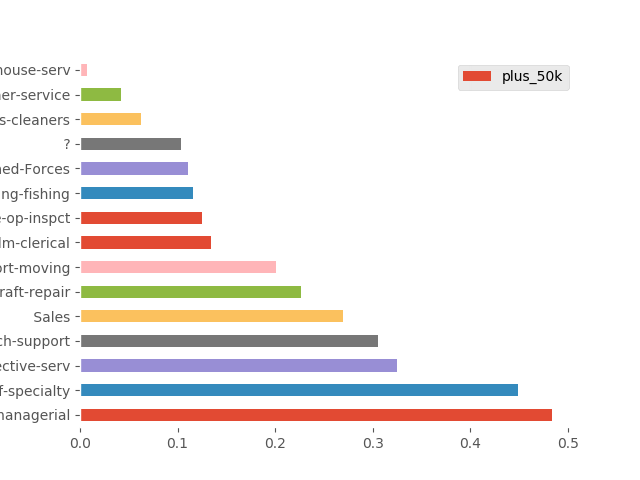

In [16]:
import matplotlib.pyplot as plt

# use ggplot style
plt.style.use('ggplot')

# get plot on  pandas data
myplot = df_pandas.plot(kind='barh', x='occupation', y='plus_50k')

# display plot (note - display() is a databricks function - 

display(myplot.figure)

In [17]:
# describe df
df_adult.select(df_adult['age'],df_adult['education_num']).describe().show()


+-------+------------------+------------------+
summary| age| education_num|
+-------+------------------+------------------+
 count| 32560| 32560|
 mean|38.581633906633904| 10.08058968058968|
 stddev|13.640641827464002|2.5727089681052058|
 min| 17.0| 1.0|
 max| 90.0| 16.0|
+-------+------------------+------------------+

In [18]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

categoricalColumns = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]
stages = [] # stages in our Pipeline

for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    # encoder = OneHotEncoderEstimator(inputCol=categoricalCol + "Index", outputCol=categoricalCol + "classVec")
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages. 
    stages += [stringIndexer, encoder]

In [19]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="income", outputCol="label")
stages += [label_stringIdx]


In [20]:
# Transform all features into a vector using VectorAssembler
numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]


In [21]:
# Create a Pipeline.
pipeline = Pipeline(stages=stages)
# Run the feature transformations.
#  - fit() computes feature statistics as needed.
#  - transform() transforms the features.
pipelineModel = pipeline.fit(df_adult)
dataset = pipelineModel.transform(df_adult)
# Keep relevant columns
selectedcols = ["label", "features"] + cols
dataset = dataset.select(selectedcols)
#display()
dataset.show(5)

+-----+--------------------+----+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
label| features| age| workclass| fnlwgt| education|education_num| marital_status| occupation| relationship| race| sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+-----+--------------------+----+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
 0.0|(100,[1,10,23,31,...|50.0| Self-emp-not-inc| 83311.0| Bachelors| 13.0| Married-civ-spouse| Exec-managerial| Husband| White| Male| 0.0| 0.0| 13.0| United-States| <=50K|
 0.0|(100,[0,8,25,38,4...|38.0| Private|215646.0| HS-grad| 9.0| Divorced| Handlers-cleaners| Not-in-family| White| Male| 0.0| 0.0| 40.0| United-States| <=50K|
 0.0|(100,[0,13,23,38,...|53.0| Private|234721.0| 11th| 7.0| Married-civ-spouse| Handlers-cleaners| Husband| Black| Male| 0.0| 0.0| 40.0| United-States| <=50K|
 0.0|(100,[0,10,23,29,...|28.0| Private|338409.0| Bachelors| 13.0| Married-civ-spouse| Prof-specialty| Wife| Black| Female| 0.0| 0.0| 40.0| Cuba| <=50K|
 0.0|(100,[0,11,23,31,...|37.0| Private|284582.0| Masters| 14.0| Married-civ-spouse| Exec-managerial| Wife| White| Female| 0.0| 0.0| 40.0| United-States| <=50K|
+-----+--------------------+----+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
only showing top 5 rows

In [22]:
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count())
print(testData.count())


22837
9723

In [23]:
from pyspark.sql.functions import avg

# get the rate of the positive outcome from the training data to use as a threshold in the model
training_data_positive_rate = trainingData.select(avg(trainingData['label'])).collect()[0][0] 

print("Positive rate in the training data is {}".format(training_data_positive_rate))

Positive rate in the training data is 0.23934842580023646

In [24]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# set threshold for the probability above which to predict a 1
lr.setThreshold(training_data_positive_rate)
# lr.setThreshold(0.5) 

# Train model with Training Data
lrModel = lr.fit(trainingData)

# get training summary used for eval metrics and other params
lrTrainingSummary = lrModel.summary

# Find the best model threshold to use instead of the empirical positve rate
fMeasure = lrTrainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
lrBestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
  
print("Best threshold based on model performance on training data is {}".format(lrBestThreshold))

Best threshold based on model performance on training data is 0.349896887684869

In [25]:
#3).Train a GBTClassifier on the training data, call the trained model 'gbModel'
from pyspark.ml.classification import GBTClassifier
gb = GBTClassifier(maxIter=10)
gbModel = gb.fit(trainingData)


In [26]:
# make predictions on test data
lrPredictions = lrModel.transform(testData)

# display predictions
#display(lrPredictions.select("label", "prediction", "probability"))
lrPredictions.select("label", "prediction", "probability").show(5)



+-----+----------+--------------------+
label|prediction| probability|
+-----+----------+--------------------+
 0.0| 1.0|[0.69126409891864...|
 0.0| 1.0|[0.62137348651550...|
 0.0| 1.0|[0.65862879486004...|
 0.0| 1.0|[0.65899585102898...|
 0.0| 1.0|[0.61577049345467...|
+-----+----------+--------------------+
only showing top 5 rows

In [27]:
#4).Get predictions on the test data for your GBTClassifier. Call the predictions df 'gbPredictions'.

In [28]:
# make predictions on test data
gbPredictions = gbModel.transform(testData)

#display(gbPredictions.select("label", "prediction", "probability"))
gbPredictions.select("label", "prediction", "probability").show(5)

+-----+----------+--------------------+
label|prediction| probability|
+-----+----------+--------------------+
 0.0| 0.0|[0.83535329707060...|
 0.0| 0.0|[0.77335390925456...|
 0.0| 0.0|[0.77335390925456...|
 0.0| 0.0|[0.77335390925456...|
 0.0| 0.0|[0.56754674995727...|
+-----+----------+--------------------+
only showing top 5 rows

In [29]:
#5).Complete the print_performance_metrics() function below to also include measures of F1, Precision, Recall, False Positive Rate and True Positive Rate.


In [30]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

def print_performance_metrics(predictions):
  # Evaluate model
  evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
  auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
  aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
  print("auc = {}".format(auc))
  print("aupr = {}".format(aupr))

  # get rdd of predictions and labels for mllib eval metrics
  predictionAndLabels = predictions.select("prediction","label").rdd

  # Instantiate metrics objects
  binary_metrics = BinaryClassificationMetrics(predictionAndLabels)
  multi_metrics = MulticlassMetrics(predictionAndLabels)
  # Area under precision-recall curve
  print("Area under PR = {}".format(binary_metrics.areaUnderPR))
  # Area under ROC curve
  print("Area under ROC = {}".format(binary_metrics.areaUnderROC))
  # Accuracy
  print("Accuracy = {}".format(multi_metrics.accuracy))
  # Confusion Matrix
  print(multi_metrics.confusionMatrix())
  
  ### Question 5.1 Answer ###
  
  # F1
  print("F1 = {}".format(multi_metrics.fMeasure()))
  # Precision
  print("Precision = {}".format(multi_metrics.precision()))
  # Recall
  print("Recall = {}".format(multi_metrics.recall()))
  confusion = multi_metrics.confusionMatrix()
  # FPR
  print("FPR = {}".format(confusion[0, 1]))
  # TPR
  print("TPR = {}".format(confusion[0, 1]))
  
  
print_performance_metrics(lrPredictions)

auc = 0.9032867661805299
aupr = 0.7627830907418989
Area under PR = 0.5366100314564946
Area under ROC = 0.8159794860040686
Accuracy = 0.80067880283863
DenseMatrix([[5776., 1572.],
 [ 366., 2009.]])
F1 = 0.80067880283863
Precision = 0.80067880283863
Recall = 0.80067880283863
FPR = 1572.0
TPR = 1572.0

In [31]:
print_performance_metrics(gbPredictions)

auc = 0.9033241841675499
aupr = 0.772880028825007
Area under PR = 0.6529222349664292
Area under ROC = 0.7568880898490101
Accuracy = 0.8522061092255476
DenseMatrix([[6931., 417.],
 [1020., 1355.]])
F1 = 0.8522061092255476
Precision = 0.8522061092255476
Recall = 0.8522061092255476
FPR = 417.0
TPR = 417.0

In [32]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bounds vector size must beequal with 1 for binomial regression, or the number oflasses for multinomial regression. (undefined)
maxIter: max number of iterations (>= 0). (default: 100, current: 10)
predictionCol: prediction column name. (default: prediction)
probabilityCol: Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities. (default: probability)
rawPredictionCol: raw prediction (a.k.a. confidence) column name. (default: rawPrediction)
regParam: regularization parameter (>= 0). (default: 0.0)
standardization: whether to standardize the training features before fitting the model. (default: True)
threshold: Threshold in binary classification prediction, in range [0, 1]. If threshold and thresholds are both set, they must match.e.g. if threshold is p, then thresholds must be equal to [1-p, p]. (default: 0.5, current: 0.23934842580023646)
thresholds: Thresholds in multi-class classification to adjust the probability of predicting each class. Array must have length equal to the number of classes, with values > 0, excepting that at most one value may be 0. The class with largest value p/t is predicted, where p is the original probability of that class and t is the class's threshold. (undefined)
tol: the convergence tolerance for iterative algorithms (>= 0). (default: 1e-06)
upperBoundsOnCoefficients: The upper bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
upperBoundsOnIntercepts: The upper bounds on intercepts if fitting under bound constrained optimization. The bound vector size must be equal with 1 for binomial regression, or the number of classes for multinomial regression. (undefined)
weightCol: weight column name. If this is not set or empty, we treat all instance weights as 1.0. (undefined)

In [33]:
print(gb.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features). default = 'auto' (default: all)
featuresCol: features column name. (default: features)
labelCol: label column name. (default: label)
lossType: Loss function which GBT tries to minimize (case-insensitive). Supported options: logistic (default: logistic)
maxBins: Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature. (default: 32)
maxDepth: Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 5)
maxIter: max number of iterations (>= 0). (default: 20, current: 10)
maxMemoryInMB: Maximum memory in MB allocated to histogram aggregation. If too small, then 1 node will be split per iteration, and its aggregates may exceed this size. (default: 256)
minInfoGain: Minimum information gain for a split to be considered at a tree node. (default: 0.0)
minInstancesPerNode: Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1. (default: 1)
predictionCol: prediction column name. (default: prediction)
seed: random seed. (default: 4358870491050797640)
stepSize: Step size (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator. (default: 0.1)
subsamplingRate: Fraction of the training data used for learning each decision tree, in range (0, 1]. (default: 1.0)

In [34]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
lrParamGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [2, 5])
             .build())


In [35]:
#6). Build out a param grid for the gb model, call it 'gbParamGrid'.

In [36]:
### Question 6.1 Answer ###

# Create ParamGrid for Cross Validation
gbParamGrid = (ParamGridBuilder()
             .addGrid(gb.maxDepth, [5,6,7])
             .addGrid(gb.maxBins, [32,33,34])
             .addGrid(gb.maxIter, [10,15])
             .build())

In [37]:
# set up an evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Create CrossValidator
lrCv = CrossValidator(estimator=lr, estimatorParamMaps=lrParamGrid, evaluator=evaluator, numFolds=2)

# Run cross validations
lrCvModel = lrCv.fit(trainingData)

In [38]:
# look at best params from the CV
print(lrCvModel.bestModel._java_obj.getRegParam())
print(lrCvModel.bestModel._java_obj.getElasticNetParam())
print(lrCvModel.bestModel._java_obj.getMaxIter())

0.01
0.0
5

In [39]:
#7).Perform cross validation of params on your 'gb' model.
#7).Print out the best params you found.

In [40]:
### Question 7.1 Answer ###

# Create CrossValidator
gbCv = CrossValidator(estimator=gb, estimatorParamMaps=gbParamGrid, evaluator=evaluator, numFolds=2)

# Run cross validations
gbCvModel = gbCv.fit(trainingData)


In [41]:
### Question 7.2 Answer ###

# look at best params from the CV
print(gbCvModel.bestModel._java_obj.getMaxIter())
print(gbCvModel.bestModel._java_obj.getMaxBins())
print(gbCvModel.bestModel._java_obj.getMaxDepth())

15
34
5

In [42]:
# Use test set to measure the accuracy of our model on new data
lrCvPredictions = lrCvModel.transform(testData)

#display(lrCvPredictions)
lrCvPredictions.show(5)

+-----+--------------------+----+---------+--------+---------+-------------+-------------------+---------------+------------+------+-----+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
label| features| age|workclass| fnlwgt|education|education_num| marital_status| occupation|relationship| race| sex|capital_gain|capital_loss|hours_per_week|native_country|income| rawPrediction| probability|prediction|
+-----+--------------------+----+---------+--------+---------+-------------+-------------------+---------------+------------+------+-----+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
 0.0|(100,[0,8,23,29,4...|26.0| Private| 58426.0| HS-grad| 9.0| Married-civ-spouse| Prof-specialty| Husband| White| Male| 0.0| 0.0| 50.0| United-States| <=50K|[0.25873328482870...|[0.56432487970099...| 1.0|
 0.0|(100,[0,8,23,29,4...|30.0| Private| 83253.0| HS-grad| 9.0| Married-civ-spouse| Prof-specialty| Husband| White| Male| 0.0| 0.0| 55.0| United-States| <=50K|[0.23884764095141...|[0.55942964898357...| 1.0|
 0.0|(100,[0,8,23,29,4...|31.0| Private| 62374.0| HS-grad| 9.0| Married-civ-spouse| Prof-specialty| Husband| White| Male| 0.0| 0.0| 50.0| United-States| <=50K|[0.24090867573821...|[0.55993756595337...| 1.0|
 0.0|(100,[0,8,23,29,4...|32.0| Private| 32732.0| HS-grad| 9.0| Married-civ-spouse| Prof-specialty| Husband| White| Male| 0.0| 0.0| 50.0| United-States| <=50K|[0.21452578973107...|[0.55342670714727...| 1.0|
 0.0|(100,[0,8,23,29,4...|39.0| Private|181705.0| HS-grad| 9.0| Married-civ-spouse| Prof-specialty| Husband| White| Male| 0.0| 0.0| 45.0| United-States| <=50K|[0.31900197250539...|[0.57908100596333...| 1.0|
+-----+--------------------+----+---------+--------+---------+-------------+-------------------+---------------+------------+------+-----+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
only showing top 5 rows

In [43]:
gbCvPredictions = gbCvModel.transform(testData)

#display(gbCvPredictions)
gbCvPredictions.show(5)

+-----+--------------------+----+---------+--------+---------+-------------+-------------------+---------------+------------+------+-----+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
label| features| age|workclass| fnlwgt|education|education_num| marital_status| occupation|relationship| race| sex|capital_gain|capital_loss|hours_per_week|native_country|income| rawPrediction| probability|prediction|
+-----+--------------------+----+---------+--------+---------+-------------+-------------------+---------------+------------+------+-----+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
 0.0|(100,[0,8,23,29,4...|26.0| Private| 58426.0| HS-grad| 9.0| Married-civ-spouse| Prof-specialty| Husband| White| Male| 0.0| 0.0| 50.0| United-States| <=50K|[0.88437949489202...|[0.85430327143277...| 0.0|
 0.0|(100,[0,8,23,29,4...|30.0| Private| 83253.0| HS-grad| 9.0| Married-civ-spouse| Prof-specialty| Husband| White| Male| 0.0| 0.0| 55.0| United-States| <=50K|[0.53970816826732...|[0.74638351455551...| 0.0|
 0.0|(100,[0,8,23,29,4...|31.0| Private| 62374.0| HS-grad| 9.0| Married-civ-spouse| Prof-specialty| Husband| White| Male| 0.0| 0.0| 50.0| United-States| <=50K|[0.57012130826167...|[0.75772418090455...| 0.0|
 0.0|(100,[0,8,23,29,4...|32.0| Private| 32732.0| HS-grad| 9.0| Married-civ-spouse| Prof-specialty| Husband| White| Male| 0.0| 0.0| 50.0| United-States| <=50K|[0.57012130826167...|[0.75772418090455...| 0.0|
 0.0|(100,[0,8,23,29,4...|39.0| Private|181705.0| HS-grad| 9.0| Married-civ-spouse| Prof-specialty| Husband| White| Male| 0.0| 0.0| 45.0| United-States| <=50K|[0.10840638261924...|[0.55399185375234...| 0.0|
+-----+--------------------+----+---------+--------+---------+-------------+-------------------+---------------+------------+------+-----+------------+------------+--------------+--------------+------+--------------------+--------------------+----------+
only showing top 5 rows

In [44]:
print_performance_metrics(lrCvPredictions)

auc = 0.8857251239148407
aupr = 0.7241684115655654
Area under PR = 0.5010764347874727
Area under ROC = 0.798374810188236
Accuracy = 0.773423840378484
DenseMatrix([[5508., 1840.],
 [ 363., 2012.]])
F1 = 0.773423840378484
Precision = 0.773423840378484
Recall = 0.773423840378484
FPR = 1840.0
TPR = 1840.0

In [45]:
print_performance_metrics(gbCvPredictions)

auc = 0.9091203334956888
aupr = 0.782041526718532
Area under PR = 0.6615325221289755
Area under ROC = 0.7616302037074177
Accuracy = 0.855497274503754
DenseMatrix([[6945., 403.],
 [1002., 1373.]])
F1 = 0.855497274503754
Precision = 0.855497274503754
Recall = 0.855497274503754
FPR = 403.0
TPR = 403.0

In [46]:
print('Model Intercept: ', lrCvModel.bestModel.intercept)

Model Intercept: -1.247913441799743

In [47]:
lrWeights = lrCvModel.bestModel.coefficients
lrWeights = [(float(w),) for w in lrWeights]  # convert numpy type to float, and to tuple
lrWeightsDF = sqlContext.createDataFrame(lrWeights, ["Feature Weight"])
display(lrWeightsDF)


Feature Weight
-0.22413336981436774
-0.3455553822296018
-0.13203533849479424
-0.4680986801474529
-0.24553588692884637
0.43228384563178
0.4075811047761166
-1.159748876366615
-0.4380095204656964
-0.19291567917419333


In [48]:
#8).Print out a table of feature_name and feature_coefficient from the Logistic Regression model. 

#Adapt the code from here: https://stackoverflow.com/questions/42935914/how-to-map-features-from-the-output-of-a-vectorassembler-back-to-the-column-name

In [49]:
from itertools import chain

lrCvFeatureImportance = pd.DataFrame(lrCvPredictions.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+lrCvPredictions.schema["features"].metadata["ml_attr"]["attrs"]["numeric"])
lrCvFeatureImportance['coefficients'] = list(lrCvModel.bestModel.coefficients)
lrCvFeatureImportance
#lrCvFeatureImportance[['name','coefficients']]

Out[65]: 
 idx name coefficients
0 0 workclassclassVec_ Private -2.241334e-01
1 1 workclassclassVec_ Self-emp-not-inc -3.455554e-01
2 2 workclassclassVec_ Local-gov -1.320353e-01
3 3 workclassclassVec_ ? -4.680987e-01
4 4 workclassclassVec_ State-gov -2.455359e-01
5 5 workclassclassVec_ Self-emp-inc 4.322838e-01
6 6 workclassclassVec_ Federal-gov 4.075811e-01
7 7 workclassclassVec_ Without-pay -1.159749e+00
8 8 educationclassVec_ HS-grad -4.380095e-01
9 9 educationclassVec_ Some-college -1.929157e-01
10 10 educationclassVec_ Bachelors 4.405790e-01
11 11 educationclassVec_ Masters 8.010314e-01
12 12 educationclassVec_ Assoc-voc -6.184804e-02
13 13 educationclassVec_ 11th -6.362003e-01
14 14 educationclassVec_ Assoc-acdm -4.723760e-02
15 15 educationclassVec_ 10th -6.577699e-01
16 16 educationclassVec_ 7th-8th -9.051719e-01
17 17 educationclassVec_ Prof-school 1.209750e+00
18 18 educationclassVec_ 9th -8.060890e-01
19 19 educationclassVec_ 12th -5.385351e-01
20 20 educationclassVec_ Doctorate 1.225138e+00
21 21 educationclassVec_ 5th-6th -7.968925e-01
22 22 educationclassVec_ 1st-4th -8.210516e-01
23 23 marital_statusclassVec_ Married-civ-spouse 6.435125e-01
24 24 marital_statusclassVec_ Never-married -7.775786e-01
25 25 marital_statusclassVec_ Divorced -4.076686e-01
26 26 marital_statusclassVec_ Separated -4.664220e-01
27 27 marital_statusclassVec_ Widowed -3.051117e-01
28 28 marital_statusclassVec_ Married-spouse-absent -4.382287e-01
29 29 occupationclassVec_ Prof-specialty 4.096262e-01
.. ... ... ...
70 70 native_countryclassVec_ Guatemala -5.882574e-01
71 71 native_countryclassVec_ Japan 8.105796e-02
72 72 native_countryclassVec_ Poland -5.668514e-01
73 73 native_countryclassVec_ Columbia -1.140475e+00
74 74 native_countryclassVec_ Taiwan -2.787147e-01
75 75 native_countryclassVec_ Haiti -6.112316e-01
76 76 native_countryclassVec_ Iran 2.611785e-03
77 77 native_countryclassVec_ Portugal -3.087035e-01
78 78 native_countryclassVec_ Nicaragua -9.708063e-01
79 79 native_countryclassVec_ Peru -8.441932e-01
80 80 native_countryclassVec_ France 2.480820e-01
81 81 native_countryclassVec_ Greece -8.397554e-01
82 82 native_countryclassVec_ Ecuador -7.953933e-01
83 83 native_countryclassVec_ Ireland -2.006434e-01
84 84 native_countryclassVec_ Hong -1.511363e-01
85 85 native_countryclassVec_ Trinadad&Tobago -4.870830e-01
86 86 native_countryclassVec_ Cambodia 3.444299e-01
87 87 native_countryclassVec_ Laos -5.636170e-01
88 88 native_countryclassVec_ Thailand -7.724215e-01
89 89 native_countryclassVec_ Yugoslavia -1.664462e-01
90 90 native_countryclassVec_ Outlying-US(Guam-USVI-etc) -9.644833e-01
91 91 native_countryclassVec_ Honduras -6.189448e-01
92 92 native_countryclassVec_ Hungary -1.034384e+00
93 93 native_countryclassVec_ Scotland 3.767879e-02
94 94 age 4.156973e-03
95 95 fnlwgt -7.498115e-07
96 96 education_num 2.483800e-02
97 97 capital_gain 4.797946e-05
98 98 capital_loss 4.456794e-04
99 99 hours_per_week 4.374664e-03

[100 rows x 3 columns]

In [50]:
from itertools import chain
pd.set_option('display.max_columns', None)
gbCvFeatureImportance = pd.DataFrame(gbCvPredictions.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+gbCvPredictions.schema["features"].metadata["ml_attr"]["attrs"]["numeric"])

lrCvFeatureImportance

Out[68]: 
 idx name coefficients
0 0 workclassclassVec_ Private -2.241334e-01
1 1 workclassclassVec_ Self-emp-not-inc -3.455554e-01
2 2 workclassclassVec_ Local-gov -1.320353e-01
3 3 workclassclassVec_ ? -4.680987e-01
4 4 workclassclassVec_ State-gov -2.455359e-01
5 5 workclassclassVec_ Self-emp-inc 4.322838e-01
6 6 workclassclassVec_ Federal-gov 4.075811e-01
7 7 workclassclassVec_ Without-pay -1.159749e+00
8 8 educationclassVec_ HS-grad -4.380095e-01
9 9 educationclassVec_ Some-college -1.929157e-01
10 10 educationclassVec_ Bachelors 4.405790e-01
11 11 educationclassVec_ Masters 8.010314e-01
12 12 educationclassVec_ Assoc-voc -6.184804e-02
13 13 educationclassVec_ 11th -6.362003e-01
14 14 educationclassVec_ Assoc-acdm -4.723760e-02
15 15 educationclassVec_ 10th -6.577699e-01
16 16 educationclassVec_ 7th-8th -9.051719e-01
17 17 educationclassVec_ Prof-school 1.209750e+00
18 18 educationclassVec_ 9th -8.060890e-01
19 19 educationclassVec_ 12th -5.385351e-01
20 20 educationclassVec_ Doctorate 1.225138e+00
21 21 educationclassVec_ 5th-6th -7.968925e-01
22 22 educationclassVec_ 1st-4th -8.210516e-01
23 23 marital_statusclassVec_ Married-civ-spouse 6.435125e-01
24 24 marital_statusclassVec_ Never-married -7.775786e-01
25 25 marital_statusclassVec_ Divorced -4.076686e-01
26 26 marital_statusclassVec_ Separated -4.664220e-01
27 27 marital_statusclassVec_ Widowed -3.051117e-01
28 28 marital_statusclassVec_ Married-spouse-absent -4.382287e-01
29 29 occupationclassVec_ Prof-specialty 4.096262e-01
.. ... ... ...
70 70 native_countryclassVec_ Guatemala -5.882574e-01
71 71 native_countryclassVec_ Japan 8.105796e-02
72 72 native_countryclassVec_ Poland -5.668514e-01
73 73 native_countryclassVec_ Columbia -1.140475e+00
74 74 native_countryclassVec_ Taiwan -2.787147e-01
75 75 native_countryclassVec_ Haiti -6.112316e-01
76 76 native_countryclassVec_ Iran 2.611785e-03
77 77 native_countryclassVec_ Portugal -3.087035e-01
78 78 native_countryclassVec_ Nicaragua -9.708063e-01
79 79 native_countryclassVec_ Peru -8.441932e-01
80 80 native_countryclassVec_ France 2.480820e-01
81 81 native_countryclassVec_ Greece -8.397554e-01
82 82 native_countryclassVec_ Ecuador -7.953933e-01
83 83 native_countryclassVec_ Ireland -2.006434e-01
84 84 native_countryclassVec_ Hong -1.511363e-01
85 85 native_countryclassVec_ Trinadad&Tobago -4.870830e-01
86 86 native_countryclassVec_ Cambodia 3.444299e-01
87 87 native_countryclassVec_ Laos -5.636170e-01
88 88 native_countryclassVec_ Thailand -7.724215e-01
89 89 native_countryclassVec_ Yugoslavia -1.664462e-01
90 90 native_countryclassVec_ Outlying-US(Guam-USVI-etc) -9.644833e-01
91 91 native_countryclassVec_ Honduras -6.189448e-01
92 92 native_countryclassVec_ Hungary -1.034384e+00
93 93 native_countryclassVec_ Scotland 3.767879e-02
94 94 age 4.156973e-03
95 95 fnlwgt -7.498115e-07
96 96 education_num 2.483800e-02
97 97 capital_gain 4.797946e-05
98 98 capital_loss 4.456794e-04
99 99 hours_per_week 4.374664e-03

[100 rows x 3 columns]

In [51]:
#9).Build and train a RandomForestClassifier and print out a table of feature importances from it.

In [52]:
### Question 9.1 Answer ###
#import rf classifier
pd.set_option('display.max_colwidth', 800)
pd.set_option('display.max_columns', None)
from pyspark.ml.classification import RandomForestClassifier
#create random forest model
rf = RandomForestClassifier()
# Train model with Training Data
rfModel = rf.fit(trainingData)
#make predictions on test data
rfPredictions = rfModel.transform(testData)


#print out feature importances
rfFeatureImportance = pd.DataFrame(rfPredictions.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+rfPredictions.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")
rfFeatureScores = pd.Series(rfModel.featureImportances.toArray()).values
rfFeatureImportance['importance'] = rfFeatureScores
rfFeatureImportance


Out[51]: 
 idx name importance
0 0 workclassclassVec_ Private 0.001327
1 1 workclassclassVec_ Self-emp-not-inc 0.000316
2 2 workclassclassVec_ Local-gov 0.000134
3 3 workclassclassVec_ ? 0.001717
4 4 workclassclassVec_ State-gov 0.000010
5 5 workclassclassVec_ Self-emp-inc 0.004448
6 6 workclassclassVec_ Federal-gov 0.001757
7 7 workclassclassVec_ Without-pay 0.000000
8 8 educationclassVec_ HS-grad 0.005992
9 9 educationclassVec_ Some-college 0.000272
10 10 educationclassVec_ Bachelors 0.017022
11 11 educationclassVec_ Masters 0.006838
12 12 educationclassVec_ Assoc-voc 0.000108
13 13 educationclassVec_ 11th 0.001121
14 14 educationclassVec_ Assoc-acdm 0.000164
15 15 educationclassVec_ 10th 0.000297
16 16 educationclassVec_ 7th-8th 0.000000
17 17 educationclassVec_ Prof-school 0.013967
18 18 educationclassVec_ 9th 0.000000
19 19 educationclassVec_ 12th 0.000032
20 20 educationclassVec_ Doctorate 0.001905
21 21 educationclassVec_ 5th-6th 0.000039
22 22 educationclassVec_ 1st-4th 0.000000
23 23 marital_statusclassVec_ Married-civ-spouse 0.184893
24 24 marital_statusclassVec_ Never-married 0.067840
25 25 marital_statusclassVec_ Divorced 0.008124
26 26 marital_statusclassVec_ Separated 0.003674
27 27 marital_statusclassVec_ Widowed 0.001533
28 28 marital_statusclassVec_ Married-spouse-absent 0.000089
29 29 occupationclassVec_ Prof-specialty 0.049225
.. ... ... ...
70 70 native_countryclassVec_ Guatemala 0.000000
71 71 native_countryclassVec_ Japan 0.000000
72 72 native_countryclassVec_ Poland 0.000000
73 73 native_countryclassVec_ Columbia 0.000048
74 74 native_countryclassVec_ Taiwan 0.000000
75 75 native_countryclassVec_ Haiti 0.000000
76 76 native_countryclassVec_ Iran 0.000047
77 77 native_countryclassVec_ Portugal 0.000097
78 78 native_countryclassVec_ Nicaragua 0.000000
79 79 native_countryclassVec_ Peru 0.000000
80 80 native_countryclassVec_ France 0.000000
81 81 native_countryclassVec_ Greece 0.000000
82 82 native_countryclassVec_ Ecuador 0.000000
83 83 native_countryclassVec_ Ireland 0.000000
84 84 native_countryclassVec_ Hong 0.000000
85 85 native_countryclassVec_ Trinadad&Tobago 0.000031
86 86 native_countryclassVec_ Cambodia 0.000134
87 87 native_countryclassVec_ Laos 0.000000
88 88 native_countryclassVec_ Thailand 0.000009
89 89 native_countryclassVec_ Yugoslavia 0.000000
90 90 native_countryclassVec_ Outlying-US(Guam-USVI-etc) 0.000000
91 91 native_countryclassVec_ Honduras 0.000000
92 92 native_countryclassVec_ Hungary 0.000000
93 93 native_countryclassVec_ Scotland 0.000000
94 94 age 0.101054
95 95 fnlwgt 0.000841
96 96 education_num 0.100151
97 97 capital_gain 0.120350
98 98 capital_loss 0.019026
99 99 hours_per_week 0.043582

[100 rows x 3 columns]